In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [79]:
data = pd.read_csv('processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [80]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

pipe_lr = Pipeline([('scaler', MinMaxScaler()), ("LR", LogisticRegression())])
pipe_lr.fit(X_train, y_train)

print(f'Accuracy на тесте LogReg: {pipe_lr.score(X_test, y_test):.3f}')
### Your code is here

pipe_svm = Pipeline([("scaler_svm", MinMaxScaler()), ("SVM", LinearSVC())]) #Конструкция pipeline всегда возвращает качество в виде accuracy при использовании метода score
pipe_svm.fit(X_train, y_train)

print(f'Accuracy на тесте SVC: {pipe_svm.score(X_test, y_test):.3f}')

Accuracy на тесте LogReg: 0.843
Accuracy на тесте SVC: 0.840


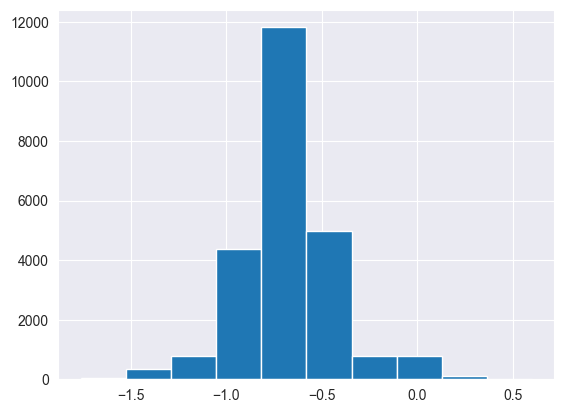

In [82]:
outputs_svm = pipe_svm.decision_function(X_test)
plt.hist(outputs_svm)
plt.show()

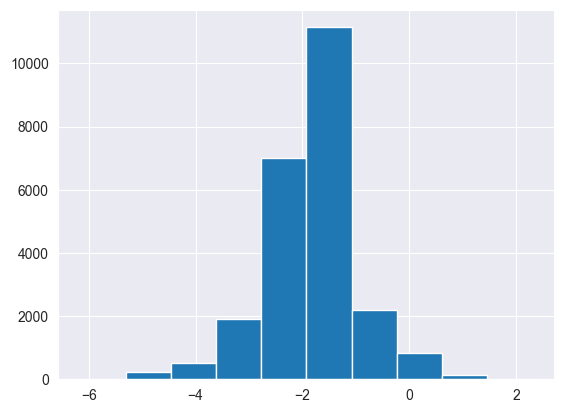

In [83]:
hist_lr = pipe_lr.decision_function(X_test)
plt.hist(hist_lr)
plt.show()

In [84]:
### Обучаем модели на трейне
### Your code is here




Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [85]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

0.6890632394427656

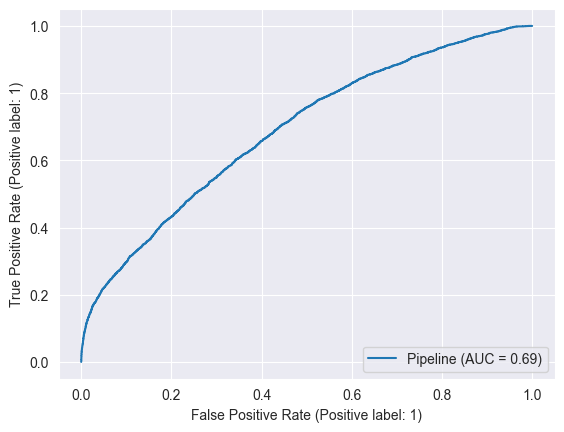

In [86]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])

RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test)
auc(fpr_lr, tpr_lr)

In [87]:
proba_svm = []
min_output_svm = min(outputs_svm)
for i in outputs_svm:
    if i <= 0:
        proba_svm.append(abs(i - min_output_svm) * 0.5 / abs(min_output_svm))
    else:
        proba_svm.append(((abs(i) * 0.5) / abs(max(outputs_svm))) + 0.5)


0.6877918464355897

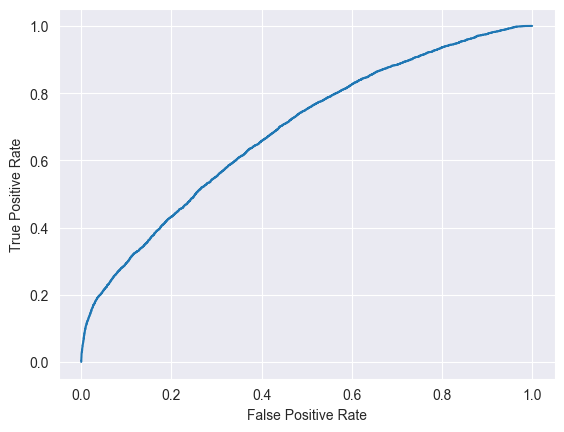

In [88]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

### Your code is here
fpr_svm, tpr_svm, threshold_svm = roc_curve(y_test, proba_svm) #Первый массив - значения FPR, второй массив - TPR, третий - трешхолды

RocCurveDisplay(fpr=fpr_svm, tpr=tpr_svm).plot()

auc(fpr_svm, tpr_svm)

In [89]:
from sklearn.metrics import auc 

### Your code is here




Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

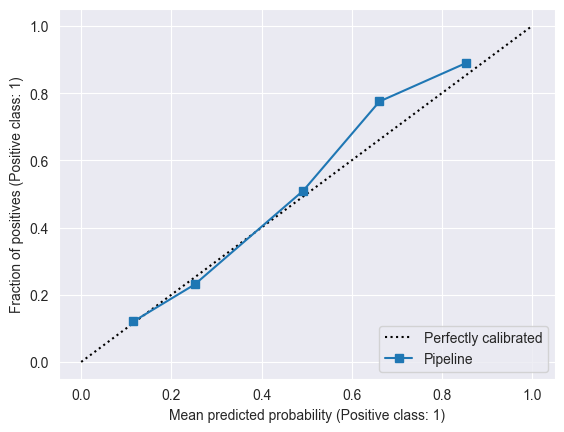

In [95]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_estimator(pipe_lr, X_test, y_test)
### Your code is here




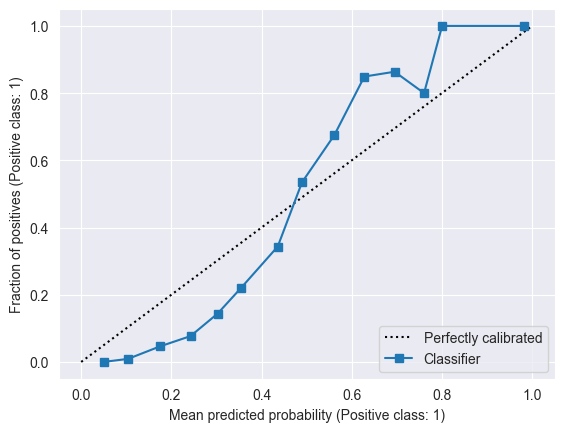

In [97]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

CalibrationDisplay.from_predictions(y_test, proba_svm, n_bins=15)
### Your code is here




**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [98]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

calibration = CalibratedClassifierCV(pipe_svm, cv=5, method='sigmoid')
calibration.fit(X_train, y_train)

calibrated_probs = calibration.predict_proba(X_test)[:, 1]




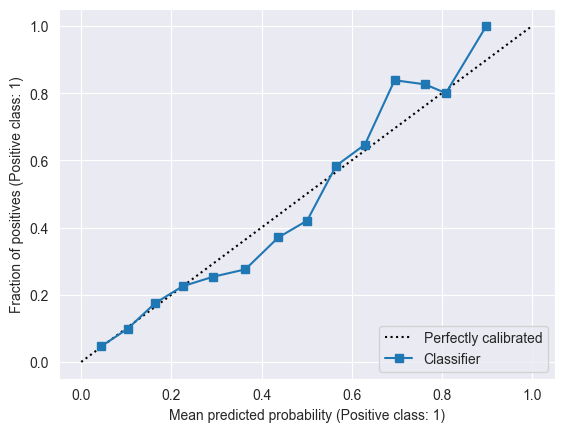

In [99]:
### Новая кривая

CalibrationDisplay.from_predictions(y_test, calibrated_probs, n_bins=15)



In [100]:
from sklearn.calibration import CalibratedClassifierCV

calibration = CalibratedClassifierCV(pipe_svm, cv=5, method='isotonic')
calibration.fit(X_train, y_train)

calibrated_probs = calibration.predict_proba(X_test)[:, 1]


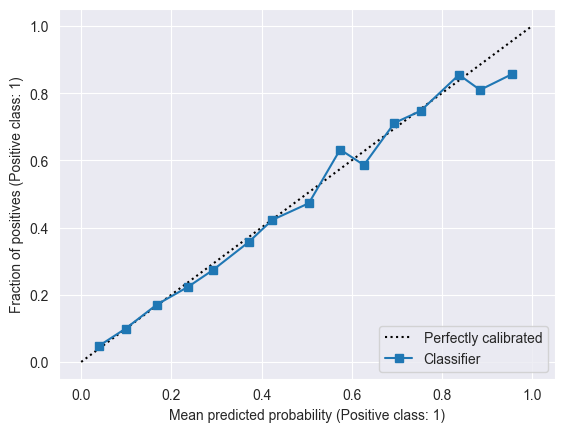

In [101]:
CalibrationDisplay.from_predictions(y_test, calibrated_probs, n_bins=15)